In [ ]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install spafe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. GTCC+XGboost pipeline I

Train Clean Acc = 1.0

Test Clean Acc = 0.7181208053691275

Test Noisy Acc = 0.8126801152737753

In [4]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
from spafe.features.gfcc import gfcc

def extract_feature(audio_file, n_gfcc=13, resample=False):
    '''
    Function to extract GFCC features from a single audio file given its path.
    '''

    audio, fs = torchaudio.load(audio_file)
    audio = audio.numpy().reshape(-1)

    if resample:
        # Note: resampling might be unnecessary for GFCC depending on your use-case
        audio = librosa.resample(audio, orig_sr=fs, target_sr=16000)
        fs = 16000  # Update the sampling rate

    # Extract GFCC features
    gfcc_features = gfcc(audio, fs=fs, num_ceps=n_gfcc)

    # You may want to take the mean, just like with MFCCs, or stack them directly
    feat_out = np.mean(gfcc_features, axis=0)

    return feat_out

In [5]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

### Extract Feature

In [5]:
#First we obtain the list of all files in the train_clean directory
train_files = glob('drive/MyDrive/24Winter/214A/project_data/train_clean/*.wav')
#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat=[]
train_label=[]

for wav in tqdm(train_files):
  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 4372/4372 [24:17<00:00,  3.00it/s]


In [6]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('drive/MyDrive/24Winter/214A/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 447/447 [01:24<00:00,  5.28it/s]


In [7]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('drive/MyDrive/24Winter/214A/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 347/347 [01:09<00:00,  5.01it/s]


### Training and SHAP

In [6]:
!pip install shap

In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd

n_gtcc = 13

feat_names = ['gtcc_' + str(n) for n in range(n_gtcc)]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


# model = xgboost.XGBClassifier()
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.6644295302013423
Test Noisy Acc = 0.8270893371757925
'''
model = xgboost.XGBClassifier(
    max_depth=15,        # 控制树的深度
    n_estimators=100,   # 树的数量
    learning_rate=0.655,  # 学习率
    gamma=0.1,          # 用于控制是否后剪枝的参数
    reg_alpha=0.005,          # L1正则化项的权重
    reg_lambda=0.1,           # L2正则化项的权重
    subsample=0.88,      # 训练每棵树时使用的样本比例
    colsample_bytree=0.8  # 训练每棵树时使用的特征比例
)
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.7181208053691275
Test Noisy Acc = 0.8126801152737753
'''
model.fit(train_feat_df, y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

In [17]:
# train_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_train.csv', )
# test_clean_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_test_clean.csv')
# test_noisy_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_test_noisy.csv')

In [40]:
train_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/gtcc13_train.csv', index_col = 0)
test_clean_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/gtcc13_test_clean.csv', index_col = 0)
test_noisy_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/gtcc13_test_noisy.csv', index_col = 0)

In [10]:
#First we obtain the list of all files in the train_clean directory
train_files = glob('drive/MyDrive/24Winter/214A/project_data/train_clean/*.wav')
#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_label=[]

for wav in tqdm(train_files):
  train_label.append(get_label(wav))

#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('drive/MyDrive/24Winter/214A/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_label=[]

for wav in tqdm(test_clean_files):
  test_clean_label.append(get_label(wav))

#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('drive/MyDrive/24Winter/214A/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_label=[]

for wav in tqdm(test_noisy_files):
  test_noisy_label.append(get_label(wav))

y_train=np.stack(train_label)
y_test_clean=np.stack(test_clean_label)
y_test_noisy=np.stack(test_noisy_label)

100%|██████████| 347/347 [00:00<00:00, 901749.37it/s]


In [42]:
import xgboost
import numpy as np
import shap
import pandas as pd
# model = xgboost.XGBClassifier()
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.6644295302013423
Test Noisy Acc = 0.8270893371757925
'''
model = xgboost.XGBClassifier(
    max_depth=15,        # 控制树的深度
    n_estimators=100,   # 树的数量
    learning_rate=0.655,  # 学习率
    gamma=0.1,          # 用于控制是否后剪枝的参数
    reg_alpha=0.005,          # L1正则化项的权重
    reg_lambda=0.1,           # L2正则化项的权重
    subsample=0.88,      # 训练每棵树时使用的样本比例
    colsample_bytree=0.8  # 训练每棵树时使用的特征比例
)
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.7181208053691275
Test Noisy Acc = 0.8126801152737753
'''
model.fit(train_feat_df, y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.7181208053691275
Test Noisy Acc = 0.8126801152737753


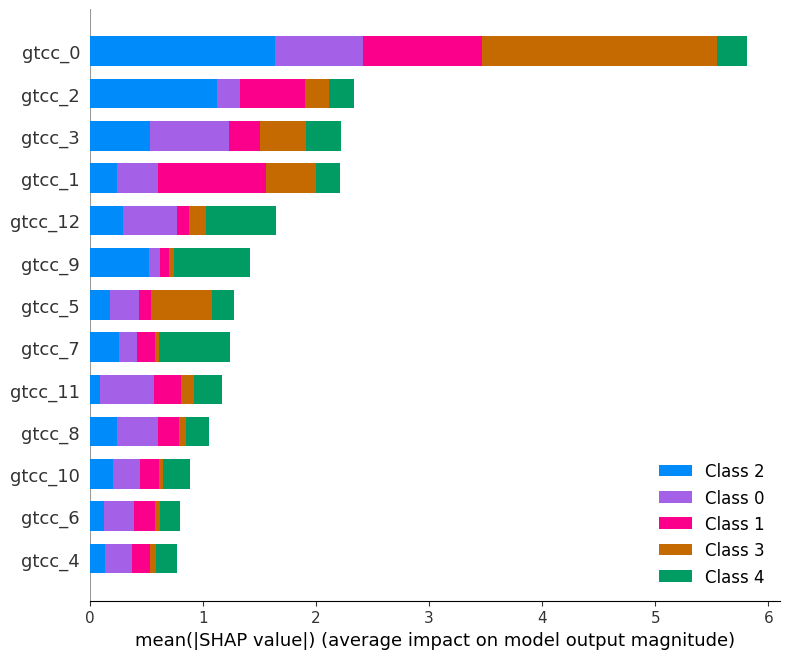

In [45]:
import matplotlib.pyplot as plt

# 获取SHAP值并创建解释器
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)

# # 对于多分类，shap_values 是一个列表，每个元素代表一个类别的SHAP值
# # 以下代码块将为每个类别绘制一个条形图
# for i in range(len(shap_values[0,0,:])):
#     # 获取第i个类别的SHAP值
#     shap.summary_plot(shap_values[:,:,i], train_feat_df, plot_type='bar', show=False, color_bar=False)
#     # plt.title(f"Class {i}")
#     # plt.show()

# 假设 shap_values 是一个形状为 (n_samples, n_features, n_classes) 的数组
shap_values_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# 之后使用这个列表作为summary_plot函数的输入
shap.summary_plot(shap_values_list, features=train_feat_df, feature_names=feat_names, plot_type="bar")


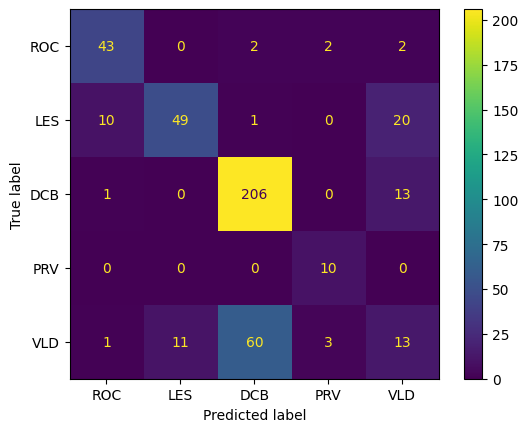

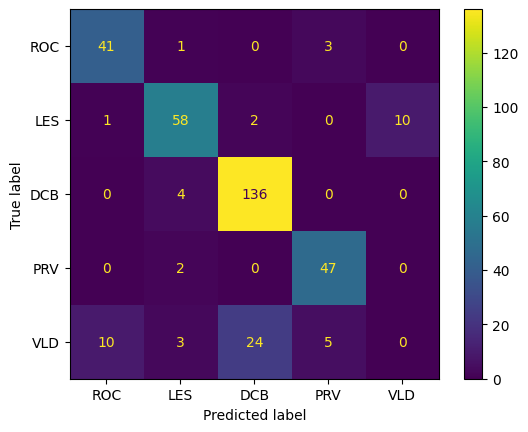

In [50]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

##2. Combine mfcc+gtcc

Train Clean Acc = 1.0

Test Clean Acc = 0.668903803131991

Test Noisy Acc = 0.6570605187319885

Delete gtcc_0

Train Clean Acc = 1.0

Test Clean Acc = 0.6644295302013423

Test Noisy Acc = 0.8270893371757925

In [55]:
select = ['gtcc_'+str(n) for n in range(0, 13)]
model = xgboost.XGBClassifier()
# model = xgboost.XGBClassifier(
#     max_depth=15,        # 控制树的深度
#     n_estimators=100,   # 树的数量
#     learning_rate=0.655,  # 学习率
#     gamma=0.1,          # 用于控制是否后剪枝的参数
#     reg_alpha=0.005,          # L1正则化项的权重
#     reg_lambda=0.1,           # L2正则化项的权重
#     subsample=0.88,      # 训练每棵树时使用的样本比例
#     colsample_bytree=0.8  # 训练每棵树时使用的特征比例
# )
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.7181208053691275
Test Noisy Acc = 0.8126801152737753
'''
model.fit(train_feat_df[select], y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df[select]))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df[select]))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df[select]))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.6644295302013423
Test Noisy Acc = 0.8270893371757925


In [70]:
feature_name1 = "mfcc13"
feature_name2 = 'gtcc13'

save_directory = 'drive/MyDrive/24Winter/214A/features'

train_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_train.csv', index_col = 0)
test_clean_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_clean.csv', index_col = 0)
test_noisy_feat1_df = pd.read_csv(f'{save_directory}/{feature_name1}_test_noisy.csv', index_col = 0)

train_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_train.csv', index_col = 0)
test_clean_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_clean.csv', index_col = 0)
test_noisy_feat2_df = pd.read_csv(f'{save_directory}/{feature_name2}_test_noisy.csv', index_col = 0)

train_new_feat_df = pd.concat([train_feat1_df, train_feat2_df], axis = 1)
test_clean_new_feat_df = pd.concat([test_clean_feat1_df, test_clean_feat2_df], axis = 1)
test_noisy_new_feat_df = pd.concat([test_noisy_feat1_df, test_noisy_feat2_df], axis = 1)

n_gtcc = 13
n_mfcc = 13

feat_names = ['gtcc_' + str(n) for n in range(n_gtcc)]
feat_new_names = ['mfcc_'+ str(n) for n in range(n_mfcc)]
feat_new_names += feat_names

In [64]:
# model = xgboost.XGBClassifier(
#     max_depth=15,        # 控制树的深度
#     n_estimators=100,   # 树的数量
#     learning_rate=0.655,  # 学习率
#     gamma=0.1,          # 用于控制是否后剪枝的参数
#     reg_alpha=0.005,          # L1正则化项的权重
#     reg_lambda=0.1,           # L2正则化项的权重
#     subsample=0.88,      # 训练每棵树时使用的样本比例
#     colsample_bytree=0.8  # 训练每棵树时使用的特征比例
# )
combined_model = xgboost.XGBClassifier()
combined_model.fit(train_new_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==combined_model.predict(train_new_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==combined_model.predict(test_clean_new_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==combined_model.predict(test_noisy_new_feat_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.668903803131991
Test Noisy Acc = 0.6570605187319885


IndexError: list index out of range

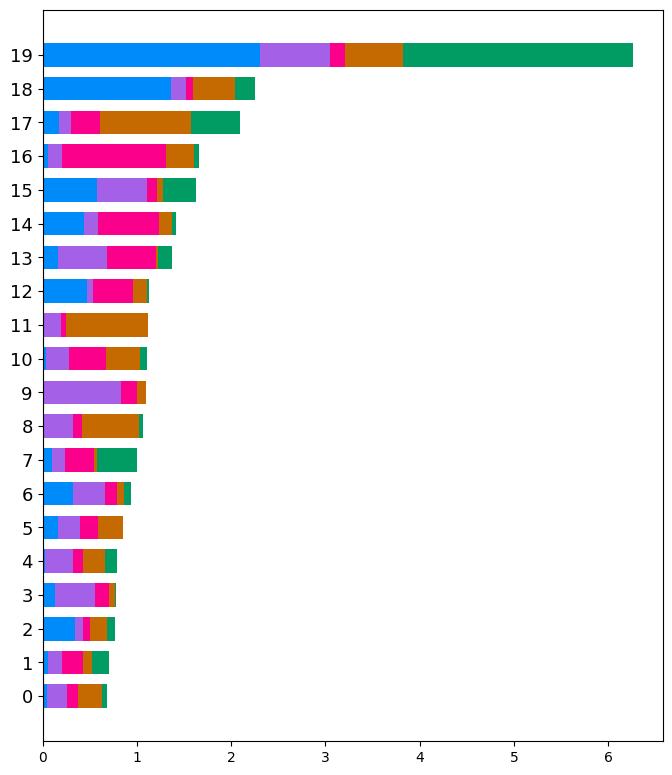

In [65]:
# 获取SHAP值并创建解释器
combined_explainer = shap.TreeExplainer(combined_model)
combined_shap_values = combined_explainer.shap_values(train_new_feat_df)

# 假设 shap_values 是一个形状为 (n_samples, n_features, n_classes) 的数组
combined_shap_values_list = [combined_shap_values[:, :, i] for i in range(combined_shap_values.shape[2])]

# 之后使用这个列表作为summary_plot函数的输入
shap.summary_plot(combined_shap_values_list, features=train_new_feat_df, feature_names=feat_new_names, plot_type="bar")

##3. Resampling the gtcc

Train Clean Acc = 1.0

Test Clean Acc = 0.6263982102908278

Test Noisy Acc = 0.6858789625360231

In [73]:
gtcc_train_feat_rs=[]

for wav in tqdm(train_files):

  gtcc_train_feat_rs.append(extract_feature(wav, resample=True))

gtcc_test_clean_feat_rs = []

for wav in tqdm(test_clean_files):

  gtcc_test_clean_feat_rs.append(extract_feature(wav, resample=True))

gtcc_test_noisy_feat_rs = []

for wav in tqdm(test_noisy_files):

  gtcc_test_noisy_feat_rs.append(extract_feature(wav, resample=True))

100%|██████████| 347/347 [00:52<00:00,  6.59it/s]


In [76]:
n_gtcc = 13

gtcc_feat_names_rs = ['gtcc_' + str(n) for n in range(n_gtcc)]

gtcc_train_feat_rs_df = pd.DataFrame(data=np.stack(gtcc_train_feat_rs), columns=gtcc_feat_names_rs)
gtcc_test_clean_feat_rs_df = pd.DataFrame(data=np.stack(gtcc_test_clean_feat_rs), columns=gtcc_feat_names_rs)
gtcc_test_noisy_feat_rs_df = pd.DataFrame(data=np.stack(gtcc_test_noisy_feat_rs), columns=gtcc_feat_names_rs)

model_gtcc_rs = xgboost.XGBClassifier()
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.6263982102908278
Test Noisy Acc = 0.6858789625360231
'''
# model_gtcc_rs = xgboost.XGBClassifier(
#     max_depth=15,        # 控制树的深度
#     n_estimators=100,   # 树的数量
#     learning_rate=0.655,  # 学习率
#     gamma=0.1,          # 用于控制是否后剪枝的参数
#     reg_alpha=0.005,          # L1正则化项的权重
#     reg_lambda=0.1,           # L2正则化项的权重
#     subsample=0.88,      # 训练每棵树时使用的样本比例
#     colsample_bytree=0.8  # 训练每棵树时使用的特征比例
# )
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.6420581655480985
Test Noisy Acc = 0.6397694524495677
'''
model_gtcc_rs.fit(gtcc_train_feat_rs_df, y_train)

print("Train Clean Acc =", np.sum(y_train==model_gtcc_rs.predict(gtcc_train_feat_rs_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model_gtcc_rs.predict(gtcc_test_clean_feat_rs_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model_gtcc_rs.predict(gtcc_test_noisy_feat_rs_df))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.6263982102908278
Test Noisy Acc = 0.6858789625360231


In [79]:
gtcc_train_feat_rs_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_rs_train.csv', )
gtcc_test_clean_feat_rs_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_rs_test_clean.csv')
gtcc_test_noisy_feat_rs_df.to_csv('drive/MyDrive/24Winter/214A/features/gtcc13_rs_test_noisy.csv')

##4. lpc extraction(Dead)

In [77]:
def extract_lpc(audio_file, n_lpc=13, resample=False):
    '''
    Function to extract multiple features from a single audio file given its path
    Modify this function to extract MFCC, LPC, pitch, and spectral contrast features
    '''

    audio, fs = torchaudio.load(audio_file)
    audio = audio.numpy().squeeze()

    if resample:
      audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

    # LPC
    lpc_coeff = librosa.lpc(audio, order=n_lpc)
    lpc_feat = np.real(lpc_coeff)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=audio, sr=fs)
    pitch_mean = np.mean(pitches[pitches > 0])

    # Concatenate features
    feat_out = np.concatenate((lpc_feat, [pitch_mean]))

    return feat_out

In [107]:
print(extract_lpc(train_files[0]))

[ 1.00000000e+00  1.08202271e+03  3.38740625e+05  3.22087740e+07
  5.94144960e+08 -2.41246234e+09  3.73101389e+09 -3.05266995e+09
  1.07281126e+09  3.36464512e+08 -2.99492160e+08 -4.81432650e+06
 -1.78555137e+04 -1.76413059e+01  1.56765540e+03]


In [78]:
lpc_train_feat_rs=[]

for wav in tqdm(train_files):

  lpc_train_feat_rs.append(extract_lpc(wav))

lpc_test_clean_feat_rs = []

for wav in tqdm(test_clean_files):

  lpc_test_clean_feat_rs.append(extract_lpc(wav))

lpc_test_noisy_feat_rs = []

for wav in tqdm(test_noisy_files):

  lpc_test_noisy_feat_rs.append(extract_lpc(wav))

100%|██████████| 347/347 [01:43<00:00,  3.36it/s]


In [101]:
print(lpc_train_feat_rs[1])
# print(len(lpc_feat_names))
print(np.isinf(lpc_train_feat_df))

[ 1.0000000e+00  4.7346325e+06  5.3749093e+12  8.4172817e+17
 -2.6692146e+18  4.4561167e+18 -5.8126716e+18  5.8222005e+18
 -4.4781808e+18  2.6935165e+18 -8.5846198e+17  4.9572824e+15
  6.9987763e+09  1.8524159e+03  1.3856322e+03]
      lpc_0  lpc_1  lpc_2  lpc_3  lpc_4  lpc_5  lpc_6  lpc_7  lpc_8  lpc_9  \
0     False  False  False  False  False  False  False  False  False  False   
1     False  False  False  False  False  False  False  False  False  False   
2     False  False  False  False  False  False  False  False  False  False   
3     False  False  False  False  False  False  False  False  False  False   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4367  False  False  False  False  False  False  False  False  False  False   
4368  False  False  False  False  False  False  False  False  False  False   
4369  False  False  False  False  False  False  False  False  False 

In [102]:
n_lpc = 13

lpc_feat_names = ['lpc_' + str(n) for n in range(n_lpc)] + ['pitch_mean'] + ['pitch_mag']

lpc_train_feat_df = pd.DataFrame(data=np.stack(lpc_train_feat_rs), columns=lpc_feat_names)
lpc_test_clean_feat_df = pd.DataFrame(data=np.stack(lpc_test_clean_feat_rs), columns=lpc_feat_names)
lpc_test_noisy_feat_df = pd.DataFrame(data=np.stack(lpc_test_noisy_feat_rs), columns=lpc_feat_names)



lpc_model = xgboost.XGBClassifier()
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.6644295302013423
Test Noisy Acc = 0.8270893371757925
'''
# lpc_model = xgboost.XGBClassifier(
#     max_depth=15,        # 控制树的深度
#     n_estimators=100,   # 树的数量
#     learning_rate=0.655,  # 学习率
#     gamma=0.1,          # 用于控制是否后剪枝的参数
#     reg_alpha=0.005,          # L1正则化项的权重
#     reg_lambda=0.1,           # L2正则化项的权重
#     subsample=0.88,      # 训练每棵树时使用的样本比例
#     colsample_bytree=0.8  # 训练每棵树时使用的特征比例
# )
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.7181208053691275
Test Noisy Acc = 0.8126801152737753
'''
lpc_model.fit(lpc_train_feat_df, y_train)

print("Train Clean Acc =", np.sum(y_train==lpc_model.predict(lpc_train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==lpc_model.predict(lpc_test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==lpc_model.predict(lpc_test_noisy_feat_df))/len(y_test_noisy))

XGBoostError: [14:27:41] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x7f470d042fba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x7f470d05a477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x7f470d049316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x7f470d04b858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x7f470cff5a07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x7f470cdb8c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f4873674e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f4873671493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f487369a3e9]



In [103]:
lpc_train_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/lpc13_train.csv', )
lpc_test_clean_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/lpc13_test_clean.csv')
lpc_test_noisy_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/lpc13_test_noisy.csv')

##5. chroma+mfcc+tempo+XGboost pipeline II

Train Clean Acc = 1.0

Test Clean Acc = 0.8210290827740492

Test Noisy Acc = 0.5302593659942363

In [105]:
import librosa
import numpy as np

def extract_chroma(audio_file, n_mfcc=13):
    '''
    Function to extract tempo, MFCC, and Chroma features from a single audio file.
    '''
    audio, fs = librosa.load(audio_file)

    # Extract tempo
    tempo, _ = librosa.beat.beat_track(y=audio, sr=fs)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=fs)
    chroma_mean = np.mean(chroma, axis=1)

    # Combine all features into a single array
    features = np.concatenate(([tempo], mfccs_mean, chroma_mean))

    return features


In [106]:
print(extract_chroma(train_files[0]))

[ 9.22851562e+01 -5.24257812e+02  1.02293358e+02 -1.01458521e+01
 -7.15974760e+00 -1.25820293e+01 -2.33220596e+01 -1.22225151e+01
 -8.84557247e+00 -1.82405796e+01 -4.03595066e+00 -1.03728142e+01
 -9.44416618e+00 -4.07462358e+00  2.65817702e-01  2.80768692e-01
  3.25052857e-01  2.80887812e-01  2.70352960e-01  2.75747210e-01
  3.38651210e-01  4.12254930e-01  4.62173074e-01  4.93464708e-01
  4.61382002e-01  3.43311578e-01]


In [108]:
chroma_train_feat=[]

for wav in tqdm(train_files):

  chroma_train_feat.append(extract_chroma(wav))

chroma_test_clean_feat = []

for wav in tqdm(test_clean_files):

  chroma_test_clean_feat.append(extract_chroma(wav))

chroma_test_noisy_feat = []

for wav in tqdm(test_noisy_files):

  chroma_test_noisy_feat.append(extract_chroma(wav))

100%|██████████| 347/347 [03:01<00:00,  1.91it/s]


In [119]:
print(chroma_test_clean_feat.shape)
# print(chroma_train_feat.shape)
print(chroma_test_noisy_feat.shape)
print(chroma_feat_names)
import numpy as np

(447, 26)
(347, 26)
['tempo', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'chroma_0', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11']


In [150]:
n_mfcc = 13  # Number of MFCC features
n_chroma = 12  # Number of Chroma features (typically 12 for each pitch class)

# Create feature names
chroma_feat_names = ['tempo'] + ['mfcc_' + str(n) for n in range(n_mfcc)] + ['chroma_' + str(n) for n in range(n_chroma)]

# Assuming train_feat_rs is a list of features for each audio file in your dataset
chroma_train_feat_df = pd.DataFrame(data=np.stack(chroma_train_feat), columns=chroma_feat_names)
chroma_test_clean_feat_df = pd.DataFrame(data=chroma_test_clean_feat, columns=chroma_feat_names)
chroma_test_noisy_feat_df = pd.DataFrame(data=chroma_test_noisy_feat, columns=chroma_feat_names)


# chroma_model = xgboost.XGBClassifier()
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.8187919463087249
Test Noisy Acc = 0.5100864553314121
'''
chroma_model = xgboost.XGBClassifier(
    max_depth=6,        # 控制树的深度
    n_estimators=100,   # 树的数量
    learning_rate=0.2,  # 学习率
    gamma=0.1,          # 用于控制是否后剪枝的参数
    reg_alpha=0.005,          # L1正则化项的权重
    reg_lambda=0.1,           # L2正则化项的权重
    subsample=0.88,      # 训练每棵树时使用的样本比例
    colsample_bytree=0.8  # 训练每棵树时使用的特征比例
)
'''
Train Clean Acc = 1.0
Test Clean Acc = 0.825503355704698
Test Noisy Acc = 0.5014409221902018
'''
chroma_model.fit(chroma_train_feat_df, y_train)

print("Train Clean Acc =", np.sum(y_train==chroma_model.predict(chroma_train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==chroma_model.predict(chroma_test_clean_feat))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==chroma_model.predict(chroma_test_noisy_feat))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.8210290827740492
Test Noisy Acc = 0.5302593659942363


In [126]:
chroma_train_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/chroma_train.csv', )
chroma_test_clean_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/chroma_test_clean.csv')
chroma_test_noisy_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/chroma_test_noisy.csv')

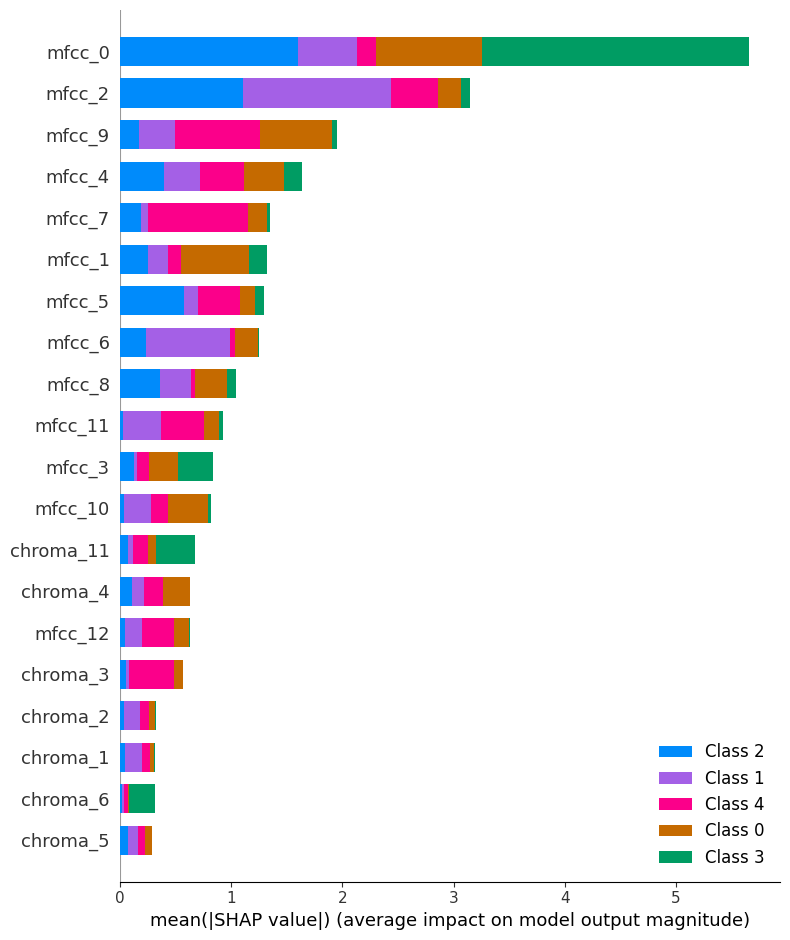

In [128]:
# 获取SHAP值并创建解释器
chroma_explainer = shap.TreeExplainer(chroma_model)
chroma_shap_values = chroma_explainer.shap_values(chroma_train_feat_df)

# 假设 shap_values 是一个形状为 (n_samples, n_features, n_classes) 的数组
chroma_shap_values_list = [chroma_shap_values[:, :, i] for i in range(chroma_shap_values.shape[2])]

# 之后使用这个列表作为summary_plot函数的输入
shap.summary_plot(chroma_shap_values_list, features=chroma_train_feat_df, feature_names=chroma_feat_names, plot_type="bar")

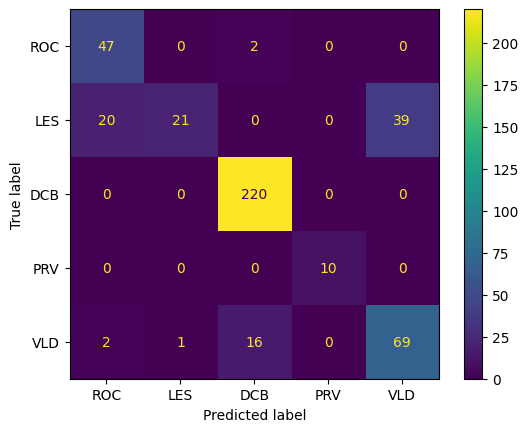

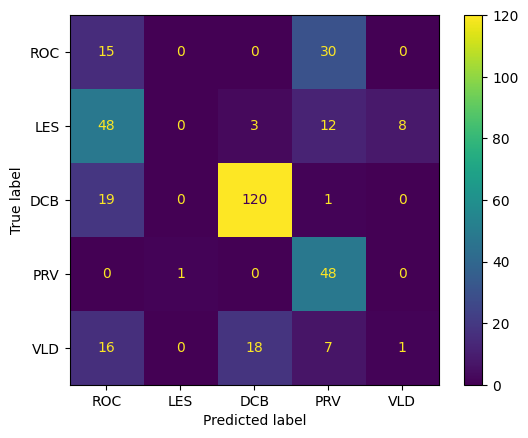

In [178]:
chroma_confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, chroma_model.predict(chroma_test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = chroma_confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

chroma_confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, chroma_model.predict(chroma_test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = chroma_confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

##6. combine pipeline I + II (selected feature)

Train Clean Acc = 1.0

Test Clean Acc = 0.814317673378076

Test Noisy Acc = 0.7521613832853026

In [160]:
feature_name3 = "chroma"

save_directory = 'drive/MyDrive/24Winter/214A/features'

train_feat3_df = pd.read_csv(f'{save_directory}/{feature_name3}_train.csv', index_col = 0)
test_clean_feat3_df = pd.read_csv(f'{save_directory}/{feature_name3}_test_clean.csv', index_col = 0)
test_noisy_feat3_df = pd.read_csv(f'{save_directory}/{feature_name3}_test_noisy.csv', index_col = 0)



train_cg_feat_df = pd.concat([train_feat2_df, train_feat3_df], axis = 1)
test_clean_cg_feat_df = pd.concat([test_clean_feat2_df, test_clean_feat3_df], axis = 1)
test_noisy_cg_feat_df = pd.concat([test_noisy_feat2_df, test_noisy_feat3_df], axis = 1)

n_gtcc = 13
n_mfcc = 13
n_chroma = 12

feat_names = ['gtcc_' + str(n) for n in range(n_gtcc)]
chroma_feat_names = ['tempo'] + ['mfcc_' + str(n) for n in range(n_mfcc)] + ['chroma_' + str(n) for n in range(n_chroma)]
feat_cg_names = feat_names + chroma_feat_names

In [363]:
# combined_cg_model = xgboost.XGBClassifier(
#     max_depth=15,        # 控制树的深度
#     n_estimators=100,   # 树的数量
#     learning_rate=0.655,  # 学习率
#     gamma=0.1,          # 用于控制是否后剪枝的参数
#     reg_alpha=0.005,          # L1正则化项的权重
#     reg_lambda=0.1,           # L2正则化项的权重
#     subsample=0.88,      # 训练每棵树时使用的样本比例
#     colsample_bytree=0.8  # 训练每棵树时使用的特征比例
# )

gtcc_num = [0,2,3,1,12,9,5,7,11,8,10,6,4]
chroma_num = [11,4,3,2,1,6]
mfcc_num = [2,9,7,1,8,5,4,3]

cg_select = ['gtcc_' + str(n) for n in gtcc_num] + ['chroma_' + str(n) for n in chroma_num] + ['mfcc_' + str(n) for n in mfcc_num]
# combined_cg_model = xgboost.XGBClassifier()
combined_cg_model = xgboost.XGBClassifier(
    max_depth=25,
    n_estimators=151,
    learning_rate=0.655,
    gamma=0.1,
    reg_alpha=0.09,
    reg_lambda=0.243,
    subsample=0.41,
    colsample_bytree=0.8
)
combined_cg_model.fit(train_cg_feat_df[cg_select],y_train)

print("Train Clean Acc =", np.sum(y_train==combined_cg_model.predict(train_cg_feat_df[cg_select]))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==combined_cg_model.predict(test_clean_cg_feat_df[cg_select]))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==combined_cg_model.predict(test_noisy_cg_feat_df[cg_select]))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.814317673378076
Test Noisy Acc = 0.7521613832853026


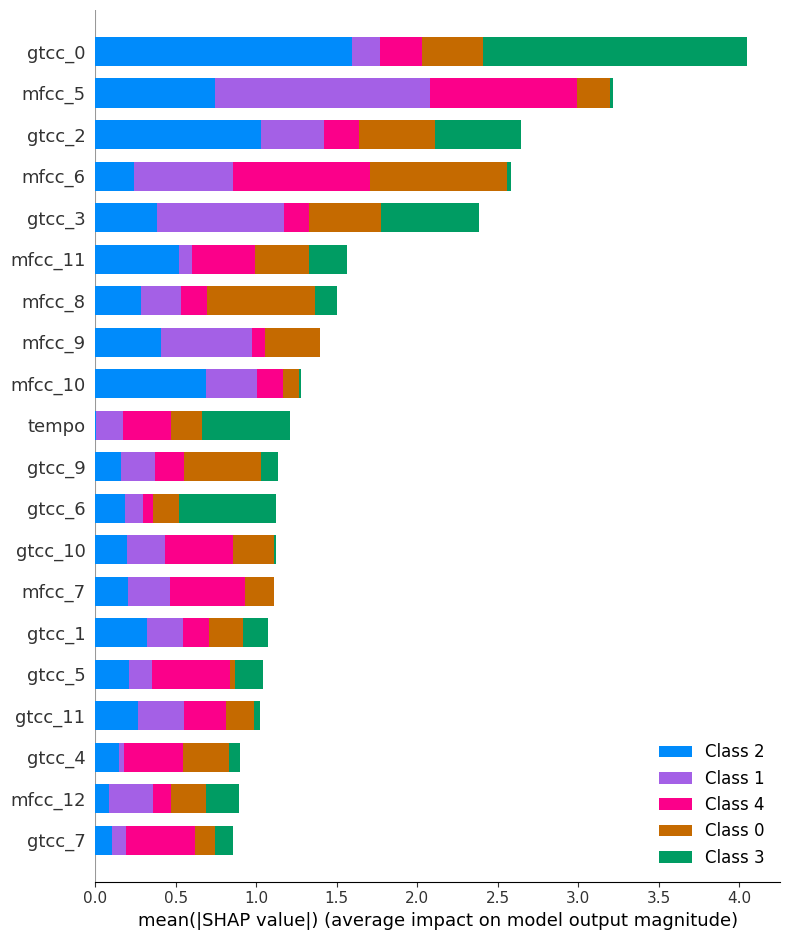

In [368]:
# 获取SHAP值并创建解释器
combined_cg_explainer = shap.TreeExplainer(combined_cg_model)
combined_cg_shap_values = combined_cg_explainer.shap_values(train_cg_feat_df[cg_select])

# 假设 shap_values 是一个形状为 (n_samples, n_features, n_classes) 的数组
combined_cg_shap_values_list = [combined_cg_shap_values[:, :, i] for i in range(combined_cg_shap_values.shape[2])]

# 之后使用这个列表作为summary_plot函数的输入
shap.summary_plot(combined_cg_shap_values_list, features=train_cg_feat_df[cg_select], feature_names=feat_cg_names, plot_type="bar")

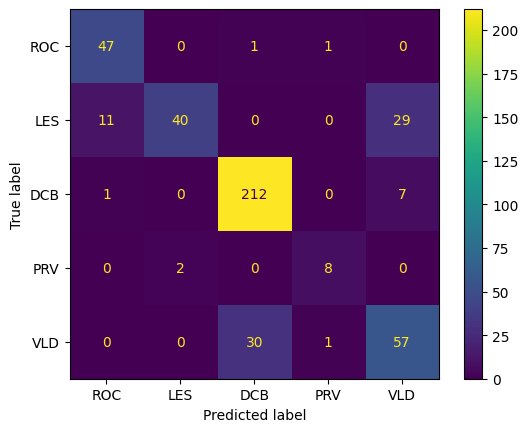

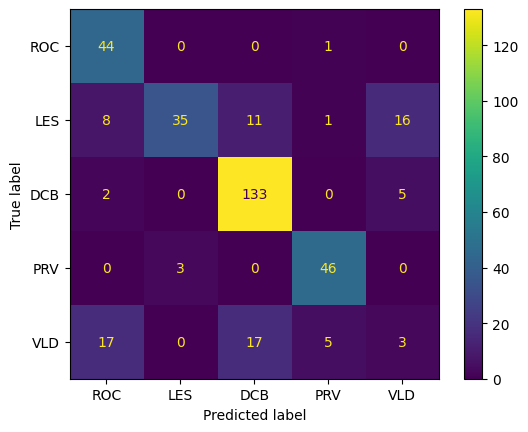

In [370]:
combined_cg_confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, combined_cg_model.predict(test_clean_cg_feat_df[cg_select]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = combined_cg_confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

combined_cg_confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, combined_cg_model.predict(test_noisy_cg_feat_df[cg_select]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = combined_cg_confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

In [371]:
train_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_train.csv', )
test_clean_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_clean.csv')
test_noisy_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_noisy.csv')